In [1]:
import invisible_cities.io.rwf_io as rwfio

In [2]:
import sys
import os
import shutil
import functools
import time
import glob

%matplotlib inline
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import pandas as pd

Running on  Mon Apr  8 12:04:16 2019


In [3]:
from matplotlib import pylab as plt

In [4]:
import numpy  as np
import tables as tb
import pandas as pd

from invisible_cities.types.ic_types import minmax
from invisible_cities.database       import load_db

from invisible_cities.core.system_of_units_c import units

from invisible_cities.reco                  import tbl_functions        as tbl
from invisible_cities.reco                  import  peak_functions      as pkf
from invisible_cities.core.random_sampling  import NoiseSampler         as SiPMsNoiseSampler
from invisible_cities.io  .        pmaps_io import          pmap_writer
from invisible_cities.io.        mcinfo_io  import       mc_info_writer
from invisible_cities.io  .run_and_event_io import run_and_event_writer
from invisible_cities.io  .trigger_io       import       trigger_writer
from invisible_cities.io  .event_filter_io  import  event_filter_writer

from invisible_cities.dataflow            import dataflow as fl
from invisible_cities.dataflow.dataflow   import push
from invisible_cities.dataflow.dataflow   import pipe
from invisible_cities.dataflow.dataflow   import sink

from invisible_cities.cities.components import city
from invisible_cities.cities.components import print_every
from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms
from invisible_cities.cities.components import zero_suppress_wfs
from invisible_cities.cities.components import WfType
from invisible_cities.cities.components import wf_from_files
# dorothea
from invisible_cities.cities.components      import peak_classifier
from invisible_cities.filters.s1s2_filter    import S12Selector
from invisible_cities.cities.components             import peak_classifier

from   invisible_cities.cities.irene       import build_pmap
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io          as dsts

from invisible_cities.icaro.hst_functions  import hist2d, hist2d_profile
from invisible_cities.core.fit_functions   import  *



## Open Dorothea Kr file:

In [5]:
demopp  = os.environ['ICTDIR'] + '/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

In [6]:
demopp

'/Users/neus/IC/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

In [7]:
sipm = load_db.DataSiPM(load_db.DetDB.demopp,519)

In [8]:
demopp

'/Users/neus/IC/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

### Open files:

In [9]:
path = '/Users/neus/current-work/data/519/kdst/trigger1/'

In [10]:
files_all = [path+f for f in os.listdir(path) if os.path.isfile( os.path.join(path, f) )]

In [11]:
#files_all

In [12]:
dsts = dsts.load_dsts(files_all, "DST", "Events")
#dst = dstf.load_dst(file_name, "DST", "Events")

In [13]:
len(dsts)

3348760

In [14]:
type(dsts)

pandas.core.frame.DataFrame

In [15]:
dsts.dtypes.index

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [16]:
dsts.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,586113,1.554560e+09,0,0,1,1,350.0,5.347312,33.547737,709675.0,...,17,99.825439,99.825439,2.738978,-8.797849,-30.208795,31.463843,-1.854192,8.892426,9.475108
1,586114,1.554560e+09,0,0,1,1,375.0,11.561908,70.249855,515250.0,...,18,289.253204,289.253204,4.311236,-9.554268,-41.786091,42.864454,-1.795579,11.728239,10.235251
2,586117,1.554560e+09,0,0,1,3,125.0,2.420022,8.780176,527575.0,...,7,276.925140,276.925140,1.889835,-1.997617,-58.558380,58.592442,-1.604896,6.177864,7.894180
3,586117,1.554560e+09,0,1,1,3,125.0,2.420022,8.780176,527575.0,...,3,667.923767,667.923767,1.497065,0.208333,2.786458,2.794236,1.496169,4.995658,4.151584
4,586117,1.554560e+09,0,2,1,3,125.0,2.420022,8.780176,527575.0,...,13,678.892883,678.892883,1.702894,-6.328530,-1.858789,6.595862,-2.855911,8.200925,8.429412


In [17]:
dsts.tail()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
512,302172,1.554551e+09,0,0,1,1,300.0,1.330530,8.800608,626200.0,...,2,177.313950,177.313950,1.556918,-39.654378,75.000000,84.837902,2.057159,4.988040,0.000000
513,302174,1.554551e+09,0,0,1,1,475.0,9.306481,48.579182,521675.0,...,14,283.804504,283.804504,2.073778,-2.620472,17.306414,17.503681,1.721071,10.139646,8.306074
514,302175,1.554551e+09,0,0,2,1,300.0,9.147213,39.248249,414950.0,...,18,389.549133,389.549133,1.943373,-7.834498,36.109596,36.949727,1.784449,11.512232,17.684606
515,302175,1.554551e+09,1,0,2,1,275.0,6.584659,38.132454,644775.0,...,18,159.724136,159.724136,1.943373,-7.834498,36.109596,36.949727,1.784449,11.512232,17.684606
516,302176,1.554551e+09,0,0,1,1,275.0,6.904041,32.592487,505400.0,...,10,299.087646,299.087646,2.139562,64.062027,5.431165,64.291841,0.084578,25.179190,12.071842


In [18]:
#d = dsts[(dsts.nS1 == 1) & (dsts.nS2 == 1) & (dsts.S2e<5500) ]
#d = dsts[(dsts.nS1 == 1) & (dsts.nS2 == 1) & (dsts.S2e<5500) & (dsts.Z<300)  ]
d = dsts[(dsts.nS1 == 1) & (dsts.nS2 == 1) & (dsts.S2e<6000) & (dsts.Z<300)  ]

In [19]:
d.dtypes.index

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

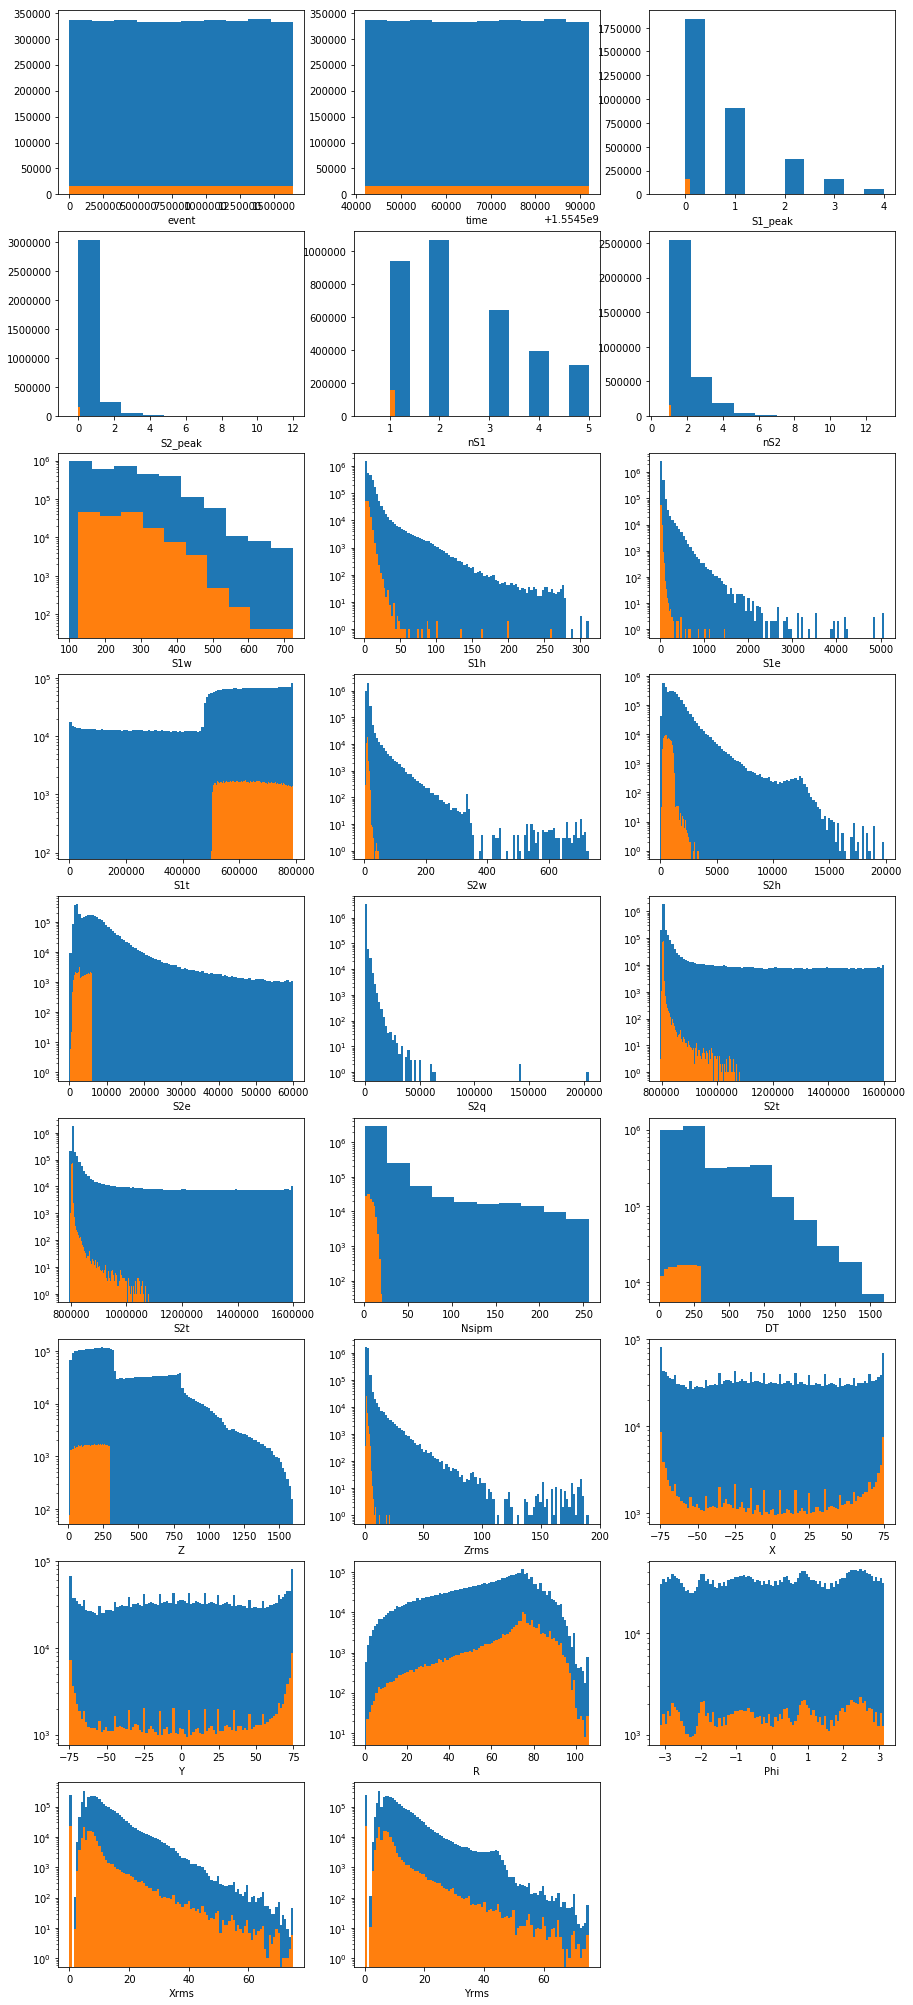

In [20]:
fig = plt.figure(figsize = (15,36))

ax2 = fig.add_subplot(9,3,1)
plt.hist(dsts.event)
plt.hist(d.event)
plt.xlabel('event')

ax2 = fig.add_subplot(9,3,2)
plt.hist(dsts.time)
plt.hist(d.time)
plt.xlabel('time')

ax2 = fig.add_subplot(9,3,3)
plt.hist(dsts.s1_peak)
plt.hist(d.s1_peak)
plt.xlabel('S1_peak')

ax2 = fig.add_subplot(9,3,4)
plt.hist(dsts.s2_peak)
plt.hist(d.s2_peak)
plt.xlabel('S2_peak')

ax2 = fig.add_subplot(9,3,5)
plt.hist(dsts.nS1)
plt.hist(d.nS1)
plt.xlabel('nS1')

ax2 = fig.add_subplot(9,3,6)
plt.hist(dsts.nS2)
plt.hist(d.nS2)
plt.xlabel('nS2')

ax2 = fig.add_subplot(9,3,7)
plt.hist(dsts.S1w)
plt.hist(d.S1w)
plt.yscale('log', nonposy='clip')
plt.xlabel('S1w')

ax2 = fig.add_subplot(9,3,8)
plt.hist(dsts.S1h,100)
plt.hist(d.S1h,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S1h')

ax2 = fig.add_subplot(9,3,9)
plt.hist(dsts.S1e,100)
plt.hist(d.S1e,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S1e')

ax2 = fig.add_subplot(9,3,10)
plt.hist(dsts.S1t,100)
plt.hist(d.S1t,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S1t')

ax2 = fig.add_subplot(9,3,11)
plt.hist(dsts.S2w,100)
plt.hist(d.S2w,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S2w')

ax2 = fig.add_subplot(9,3,12)
plt.hist(dsts.S2h,100)
plt.hist(d.S2h,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S2h')

ax2 = fig.add_subplot(9,3,13)
plt.hist(dsts.S2e[dsts.S2e<60000],100)
plt.hist(d.S2e[d.S2e<60000],100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S2e')

ax2 = fig.add_subplot(9,3,14)
plt.hist(dsts.S2q,100)
plt.hist(d.S2q,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('S2q')

ax2 = fig.add_subplot(9,3,15)
plt.hist(dsts.S2t,100)
plt.hist(d.S2t,100)
plt.xlabel('S2t')
plt.yscale('log', nonposy='clip')

ax2 = fig.add_subplot(9,3,16)
plt.hist(dsts.S2t,100)
plt.hist(d.S2t,100)
plt.xlabel('S2t')
plt.yscale('log', nonposy='clip')

ax2 = fig.add_subplot(9,3,17)
plt.hist(dsts.Nsipm)
plt.hist(d.Nsipm)
plt.yscale('log', nonposy='clip')
plt.xlabel('Nsipm')

ax2 = fig.add_subplot(9,3,18)
plt.hist(dsts.DT)
plt.hist(d.DT)
plt.yscale('log', nonposy='clip')
plt.xlabel('DT')

ax2 = fig.add_subplot(9,3,19)
plt.hist(dsts.Z,100)
plt.hist(d.Z,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Z')

ax2 = fig.add_subplot(9,3,20)
plt.hist(dsts.Zrms,100)
plt.hist(d.Zrms,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Zrms')

ax2 = fig.add_subplot(9,3,21)
plt.hist(dsts.X,100)
plt.hist(d.X,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('X')

ax2 = fig.add_subplot(9,3,22)
plt.hist(dsts.Y,100)
plt.hist(d.Y,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Y')

ax2 = fig.add_subplot(9,3,23)
plt.hist(dsts.R,100)
plt.hist(d.R,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('R')

ax2 = fig.add_subplot(9,3,24)
plt.hist(dsts.Phi,100)
plt.hist(d.Phi,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Phi')

ax2 = fig.add_subplot(9,3,25)
plt.hist(dsts.Xrms,100)
plt.hist(d.Xrms,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Xrms')

ax2 = fig.add_subplot(9,3,26)
plt.hist(dsts.Yrms,100)
plt.hist(d.Yrms,100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Yrms')

plt.show()

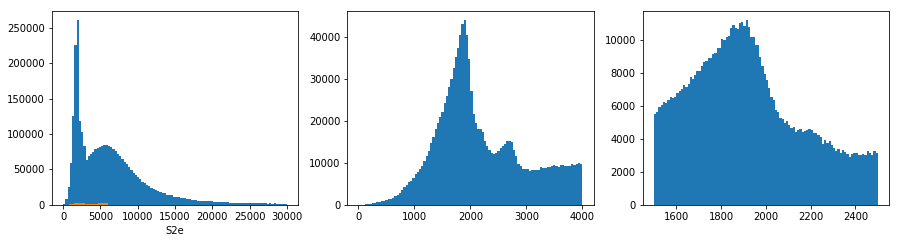

In [21]:
fig = plt.figure(figsize = (15,25))

ax2 = fig.add_subplot(6,3,1)
plt.hist(dsts.S2e[dsts.S2e<30000],100)
plt.hist(d.S2e[d.S2e<30000],100)
plt.xlabel('S2e')

ax2 = fig.add_subplot(6,3,2)
plt.hist(dsts.S2e[dsts.S2e<4000],100)

ax2 = fig.add_subplot(6,3,3)
plt.hist(dsts.S2e[(dsts.S2e<2500) & (dsts.S2e>1500)],100)

plt.show()

### Correlations: no selection

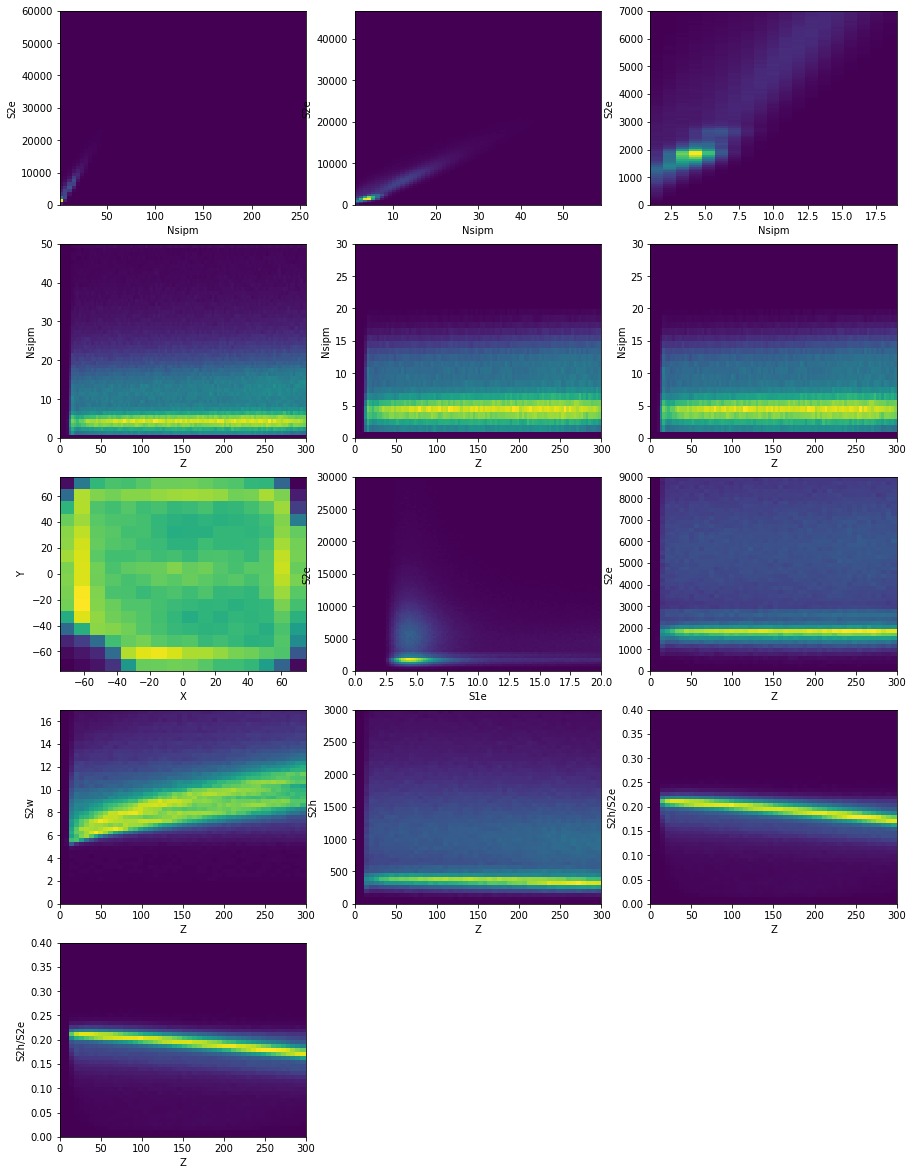

In [22]:
fig = plt.figure(figsize = (15,25))

ax2 = fig.add_subplot(6,3,1)
plt.hist2d(dsts.Nsipm[dsts.S2e<60000], dsts.S2e[dsts.S2e<60000],[59,59])
plt.xlabel('Nsipm')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,2)
plt.hist2d(dsts.Nsipm[(dsts.S2e<60000) & (dsts.Nsipm <60)], dsts.S2e[(dsts.S2e<60000) & (dsts.Nsipm <60)],[59,100])
plt.xlabel('Nsipm')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,3)
plt.hist2d(dsts.Nsipm[(dsts.S2e<7000) & (dsts.Nsipm <20)], dsts.S2e[(dsts.S2e<7000) & (dsts.Nsipm <20)],[19,100])
plt.xlabel('Nsipm')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,4)
plt.hist2d(dsts.Z, dsts.Nsipm,[100,50],[[0,300],[0,50]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,5)
plt.hist2d(dsts.Z[(dsts.S2e<7000) & (dsts.Nsipm <20)], dsts.Nsipm[(dsts.S2e<7000) & (dsts.Nsipm <20)],[100,30],[[0,300],[0,30]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,6)
plt.hist2d(dsts.Z[(dsts.S2e<7000) & (dsts.Nsipm <20)], dsts.Nsipm[(dsts.S2e<7000) & (dsts.Nsipm <20)],[100,30],[[0,300],[0,30]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,7)
plt.hist2d(dsts.X[dsts.Nsipm>7.5],dsts.Y[dsts.Nsipm>7.5],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,8)
plt.hist2d(dsts.S1e[dsts.S2e<60000],dsts.S2e[dsts.S2e<60000],100,[[0,20],[0,30000]])
plt.xlabel('S1e')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,9)
plt.hist2d(dsts.Z, dsts.S2e,50,[[0,300],[0,9000]])
plt.xlabel('Z')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,10)
plt.hist2d(dsts.Z, dsts.S2w,50,[[0,300],[0,17]])
plt.xlabel('Z')
plt.ylabel('S2w')

ax2 = fig.add_subplot(6,3,11)
plt.hist2d(dsts.Z, dsts.S2h,50,[[0,300],[0,3000]])
plt.xlabel('Z')
plt.ylabel('S2h')

S2ratio = dsts.S2h/dsts.S2e
ax2 = fig.add_subplot(6,3,12)
plt.hist2d(dsts.Z, S2ratio,50,[[0,300],[0,0.4]])
plt.xlabel('Z')
plt.ylabel('S2h/S2e')

ax2 = fig.add_subplot(6,3,13)
plt.hist2d(dsts.Z, S2ratio,50,[[0,300],[0,0.4]])
plt.xlabel('Z')
plt.ylabel('S2h/S2e')

plt.show()

### Correlations: Selection 
#### d = dsts[(dsts.nS1 == 1) & (dsts.nS2 == 1) & (dsts.S2e<5500) & ]

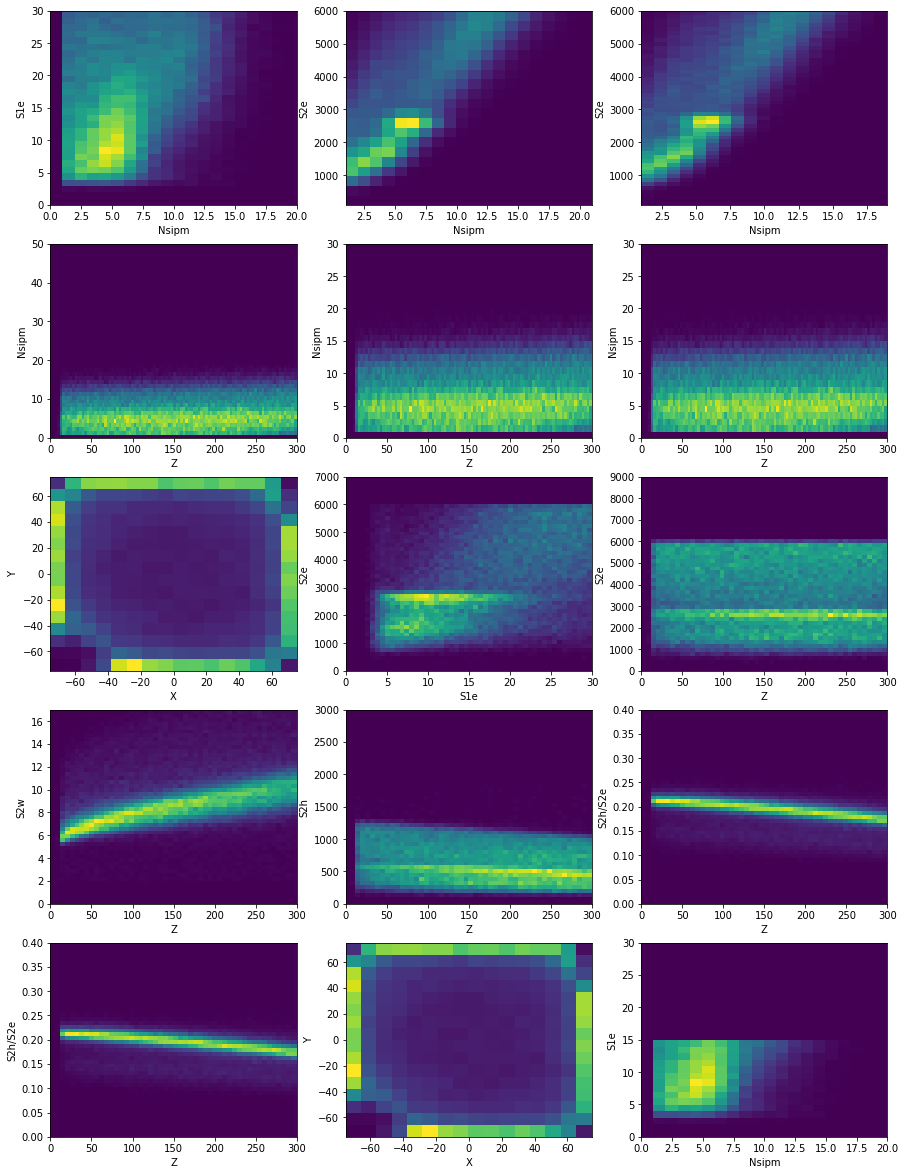

In [23]:
fig = plt.figure(figsize = (15,25))


ax2 = fig.add_subplot(6,3,1)
plt.hist2d(d.Nsipm, d.S1e,[20,30], [[0,20],[0,30]])
plt.xlabel('Nsipm')
plt.ylabel('S1e')

ax2 = fig.add_subplot(6,3,2)
plt.hist2d(d.Nsipm[(d.S2e<60000) & (d.Nsipm <60)], d.S2e[(d.S2e<60000) & (d.Nsipm <60)],20)
plt.xlabel('Nsipm')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,3)
plt.hist2d(d.Nsipm[(d.S2e<7000) & (d.Nsipm <20)], d.S2e[(d.S2e<7000) & (d.Nsipm <20)],[19,50])
plt.xlabel('Nsipm')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,4)
plt.hist2d(d.Z, d.Nsipm,[100,50],[[0,300],[0,50]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,5)
plt.hist2d(d.Z[(d.S2e<7000) & (d.Nsipm <20)], d.Nsipm[(d.S2e<7000) & (d.Nsipm <20)],[100,30],[[0,300],[0,30]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,6)
plt.hist2d(d.Z[(d.S2e<7000) & (d.Nsipm <20)], d.Nsipm[(d.S2e<7000) & (d.Nsipm <20)],[100,30],[[0,300],[0,30]])
plt.xlabel('Z')
plt.ylabel('Nsipm')

ax2 = fig.add_subplot(6,3,7)
plt.hist2d(d.X,d.Y,[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,8)
plt.hist2d(d.S1e,d.S2e,50,[[0,30],[0,7000]])
plt.xlabel('S1e')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,9)
plt.hist2d(d.Z, d.S2e,50,[[0,300],[0,9000]])
plt.xlabel('Z')
plt.ylabel('S2e')

ax2 = fig.add_subplot(6,3,10)
plt.hist2d(d.Z, d.S2w,50,[[0,300],[0,17]])
plt.xlabel('Z')
plt.ylabel('S2w')

ax2 = fig.add_subplot(6,3,11)
plt.hist2d(d.Z, d.S2h,50,[[0,300],[0,3000]])
plt.xlabel('Z')
plt.ylabel('S2h')

S2ratio = d.S2h/d.S2e
ax2 = fig.add_subplot(6,3,12)
plt.hist2d(d.Z, S2ratio,50,[[0,300],[0,0.4]])
plt.xlabel('Z')
plt.ylabel('S2h/S2e')

ax2 = fig.add_subplot(6,3,13)
plt.hist2d(d.Z, S2ratio,50,[[0,300],[0,0.4]])
plt.xlabel('Z')
plt.ylabel('S2h/S2e')

ax2 = fig.add_subplot(6,3,14)
plt.hist2d(d.X,d.Y,[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,15)
plt.hist2d(d.Nsipm[d.S1e<15], d.S1e[d.S1e<15],[20,30], [[0,20],[0,30]])
plt.xlabel('Nsipm')
plt.ylabel('S1e')

plt.show()

### Correlations: Selection 
#### d = dsts[(dsts.nS1 == 1) & (dsts.nS2 == 1) & (dsts.S2e<5500)]

In [24]:
#sel = d[(d.S1e<20) & (d.Nsipm <12)]

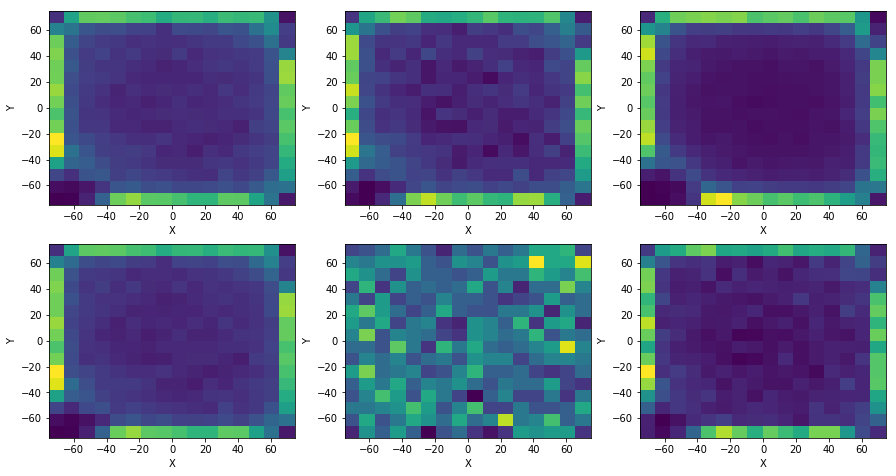

In [25]:
fig = plt.figure(figsize = (15,25))

ax2 = fig.add_subplot(6,3,1)
plt.hist2d(d.X[(d.S1e<20)], d.Y[(d.S1e<20)],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,2)
plt.hist2d(d.X[d.S1e<10],d.Y[d.S1e<10],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,3)
plt.hist2d(d.X[d.S1e>20],d.Y[d.S1e>20],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,4)
plt.hist2d(d.X[(d.S1e<20) & (d.Nsipm <12)], d.Y[(d.S1e<20) & (d.Nsipm <12)],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,5)
plt.hist2d(d.X[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm >7.5)], d.Y[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm >7.5)],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

ax2 = fig.add_subplot(6,3,6)
plt.hist2d(d.X[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm <5)], d.Y[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm <5)],[16,16], [[-75,75],[-75,75]])
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

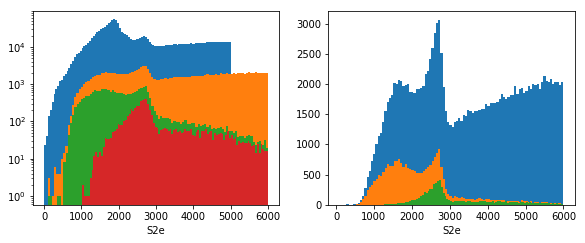

In [34]:
fig = plt.figure(figsize = (15,25))

ax2 = fig.add_subplot(6,3,1)
plt.hist(dsts.S2e[dsts.S2e<5000],100)
plt.hist(d.S2e,100)
plt.hist(d.S2e[(d.S1e<10) & (d.Nsipm <12)],100)
plt.hist(d.S2e[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm >5)],100)
plt.xlabel('S2e')
plt.yscale('log', nonposy='clip')

ax2 = fig.add_subplot(6,3,2)
plt.hist(d.S2e,100)
plt.hist(d.S2e[(d.S1e<10) & (d.Nsipm <12)],100)
plt.hist(d.S2e[(d.S1e<10) & (d.Nsipm <12) & (d.Nsipm >5)],100)
plt.xlabel('S2e')

plt.show()